In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.cluster.hierarchy import linkage, dendrogram
from numpy.linalg import eigh, inv, svd
import string

In [14]:
data = {
    'x': np.array([6, 4, 2, 5, 3, 4, 3, 4]),
    'y': np.array([3, 2, 3, 3, 2, 2, 1, 2]),
    'z': np.array([2, 3, 5, 5, 2, 3, 4, 5])
}
letters_idxs = list(string.ascii_uppercase[:len(data['x'])])

In [15]:
df = pd.DataFrame(data, index=letters_idxs)

In [16]:
def _safe_inv(mat, eps=1e-8):
    """Обратная матрица с регуляризацией по диагонали."""
    mat = mat.copy()
    diag = np.diag(mat)
    mat += np.eye(mat.shape[0]) * (eps * max(1.0, diag.max() if diag.size else 1.0))
    return inv(mat)

def _plot_3d_ellipsoid(ax, center, cov, scale=1.05, color=(0.5, 0.5, 0.5), alpha=0.18, n_u=30, n_v=15):
    """
    Рисует 3D-эллипсоид, соответствующий матрице ковариации cov,
    центрированный в center. Эллипсоид масштабируется так, чтобы
    покрыть точки (см. вычисление масштаба извне).
    """
    # Eigen decomposition
    vals, vecs = eigh(cov)
    vals = np.maximum(vals, 1e-12)  # убрать возможные отрицательные/нулевые
    # unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, n_u)
    v = np.linspace(0.0, np.pi, n_v)
    u, v = np.meshgrid(u, v)
    xs = np.cos(u) * np.sin(v)
    ys = np.sin(u) * np.sin(v)
    zs = np.cos(v)
    sphere = np.stack([xs.flatten(), ys.flatten(), zs.flatten()])  # 3 x (n_u*n_v)

    # transform: scale by sqrt(eigenvalues) and rotate by eigenvectors
    transform = vecs @ np.diag(np.sqrt(vals))
    points = (transform @ sphere).T  # (n_points, 3)

    # scale uniformly by scale factor applied externally (scale is scalar)
    points = points * scale

    # shift to center
    X = points[:, 0].reshape(xs.shape) + center[0]
    Y = points[:, 1].reshape(xs.shape) + center[1]
    Z = points[:, 2].reshape(xs.shape) + center[2]

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, color=color, alpha=alpha, linewidth=0, shade=True)

def _plane_patch(ax, midpoint, normal, data_bbox, size_factor=1.2, color=(0.7,0.7,0.7), alpha=0.12):
    """
    Рисует прямоугольный кусок плоскости с нормалью normal, проходящей через midpoint.
    Размер берётся от bbox данных * size_factor.
    """
    # нормализуем нормаль
    n = normal / np.linalg.norm(normal)
    # найдём два ортогональных вектора в плоскости
    # возьмём любой вектор, не параллельный n
    arbitrary = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(arbitrary, n)) > 0.9:
        arbitrary = np.array([0.0, 1.0, 0.0])
    v1 = np.cross(n, arbitrary)
    v1 /= np.linalg.norm(v1)
    v2 = np.cross(n, v1)
    v2 /= np.linalg.norm(v2)

    # размер патча: используем диапазоны bbox
    ranges = data_bbox[1] - data_bbox[0]
    max_range = np.max(ranges) * size_factor
    # формируем сетку по двум направлениям
    grid = np.linspace(-max_range/2, max_range/2, 10)
    U, V = np.meshgrid(grid, grid)
    pts = midpoint.reshape(1,3) + (U[...,None] * v1.reshape(1,3)) + (V[...,None] * v2.reshape(1,3))
    X = pts[...,0]
    Y = pts[...,1]
    Z = pts[...,2]
    ax.plot_surface(X, Y, Z, color=color, alpha=alpha, linewidth=0, shade=False)

def plot_3d_clusters_with_boundaries(X, labels, centroids, names, title):
    """
    3D-визуализация:
    - точки и подписи
    - 3D-эллипсоиды, покрывающие все точки кластера (через махаланобисово расстояние)
    - линии между центроидами с подписью расстояний
    - разделяющие плоскости между парами центроидов (перпендикулярные биссектрисы)
    - тренд-линии (первая PC) внутри кластера
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    k = len(np.unique(labels))
    colors = plt.cm.tab10.colors

    # data bbox (для размеров плоскостей)
    data_bbox = np.array([X.min(axis=0), X.max(axis=0)])

    for i in range(k):
        idx = np.where(labels == i)[0]
        pts = X[idx]
        if pts.size == 0:
            continue
        color = colors[i % len(colors)]

        # scatter points
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], color=color, label=f'Кластер {i+1}', s=40, alpha=0.9, depthshade=True)
        for j, pidx in enumerate(idx):
            ax.text(pts[j,0], pts[j,1], pts[j,2], names[pidx], fontsize=8)

        # covariance + regularize
        if len(pts) > 1:
            cov = np.cov(pts.T)
        else:
            cov = np.eye(3) * 1e-3

        # ensure positive-definite
        vals, vecs = eigh(cov)
        vals = np.maximum(vals, 1e-12)
        cov_pd = vecs @ np.diag(vals) @ vecs.T

        # compute Mahalanobis distances squared from centroid
        c = centroids[i]
        inv_cov = _safe_inv(cov_pd)
        diffs = pts - c
        d2 = np.einsum('ij,ij->i', diffs @ inv_cov, diffs)  # squared Mahalanobis
        max_d2 = float(np.max(d2)) if len(d2) > 0 else 1.0
        # add small margin
        scale = np.sqrt(max(1.0, max_d2)) * 1.05

        # plot ellipsoid scaled so that points are inside
        _plot_3d_ellipsoid(ax, c, cov_pd, scale=scale, color=color, alpha=0.18)

        # trend: первая главная компонента через центроид
        # PCA via SVD on centered pts
        if len(pts) > 1:
            U, S, Vt = svd(diffs, full_matrices=False)
            pc1 = Vt[0]
            # длина тренда: возьмём максим проекции точек на pc1
            projections = diffs @ pc1
            max_proj = np.max(np.abs(projections))
            if max_proj < 1e-6:
                max_proj = np.max(np.linalg.norm(diffs, axis=1))
            t = np.linspace(-max_proj*1.1, max_proj*1.1, 2)
            line_pts = c.reshape(1,3) + np.outer(t, pc1)
            ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2], color=color, linewidth=2.2, linestyle='-', alpha=0.9)

    # центроиды и расстояния между ними + разделяющие плоскости
    ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='k', marker='X', s=140, label='Центры кластеров', zorder=10)

    # линии и плоскости между центроидами
    for i in range(k):
        for j in range(i+1, k):
            c1 = centroids[i]
            c2 = centroids[j]
            # линия и расстояние
            ax.plot([c1[0], c2[0]], [c1[1], c2[1]], [c1[2], c2[2]], 'k--', alpha=0.6)
            mid = (c1 + c2) / 2.0
            dist = np.linalg.norm(c1 - c2)
            ax.text(mid[0], mid[1], mid[2], f"{dist:.2f}", color='red', fontsize=9)

            # разделяющая плоскость: нормаль = c2 - c1, проходит через mid
            normal = c2 - c1
            _plane_patch(ax, mid, normal, data_bbox, size_factor=1.2, color=(0.2,0.2,0.2), alpha=0.12)

    ax.set_title(title)
    ax.set_xlabel('X (цена)')
    ax.set_ylabel('Y (вес)')
    ax.set_zlabel('Z (объем)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("=== Уравнения разделяющих плоскостей ===")
    for i in range(k):
        for j in range(i+1,k):
            c1 = centroids[i]; c2 = centroids[j]
            mid = (c1+c2)/2
            normal = c2 - c1
            a,b,c = normal
            d = -np.dot(normal, mid)
            print(f"Между кластером {i} и {j}: {a:.3f}*x + {b:.3f}*y + {c:.3f}*z + {d:.3f} = 0")
            # линии и плоскости
            ax.plot([c1[0],c2[0]],[c1[1],c2[1]],[c1[2],c2[2]],'k--',alpha=0.6)
            _plane_patch(ax, mid, normal, data_bbox, size_factor=1.2, color=(0.2,0.2,0.2), alpha=0.12)

    ax.set_title(title)
    ax.set_xlabel('X (цена)')
    ax.set_ylabel('Y (вес)')
    ax.set_zlabel('Z')
    ax.legend()
    plt.tight_layout()
    plt.show()


def k_means(data, k=3, max_iter=20, random_state=42):
    """
    k-means на 3 признака (x,y,z) с 3D-визуализацией и финальным анализом.
    Возвращает (data_with_cluster, centroids, errors)
    """
    if not all(col in data.columns for col in ('x','y','z')):
        raise ValueError("DataFrame должен иметь столбцы 'x','y','z'.")

    np.random.seed(random_state)
    X = data[['x','y','z']].values.astype(float)
    names = data.index.tolist()

    # init centroids (random unique points)
    idx0 = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[idx0].astype(float)
    errors = []

    for it in range(max_iter):
        # assign
        dists = np.linalg.norm(X[:,None,:] - centroids[None,:,:], axis=2)
        labels = np.argmin(dists, axis=1)

        # visualize iteration
        plot_3d_clusters_with_boundaries(X, labels, centroids, names, title=f"Итерация {it+1}")

        # recompute centroids
        old_centroids = centroids.copy()
        for i in range(k):
            pts = X[labels == i]
            if pts.size == 0:
                # если пустой кластер — оставляем центроид как есть (или можно реклассифицировать)
                continue
            centroids[i] = pts.mean(axis=0)

        # error
        sse = np.sum((X - centroids[labels])**2)
        errors.append(float(sse))

        if np.allclose(old_centroids, centroids, atol=1e-6):
            print(f"Сошлось на итерации {it+1}")
            break

    data = data.copy()
    data['cluster'] = labels

    # финальная визуализация (с границами, плоскостями, трендами)
    plot_3d_clusters_with_boundaries(X, labels, centroids, names, title='Итоговое распределение кластеров (3D)')

    # график ошибки
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(errors)+1), errors, marker='o')
    plt.title('График ошибки (SSE) по итерациям')
    plt.xlabel('Итерация')
    plt.ylabel('SSE')
    plt.tight_layout()
    plt.show()

    # дендрограмма (иерархия по исходным точкам, 2D)
    plt.figure(figsize=(8,4))
    linkage_matrix = linkage(X, method='ward')
    dendrogram(linkage_matrix, labels=names)
    plt.title('Дендрограмма (иерархическая кластеризация)')
    plt.xlabel('Точки')
    plt.ylabel('Расстояние')
    plt.tight_layout()
    plt.show()

    return data, centroids, errors

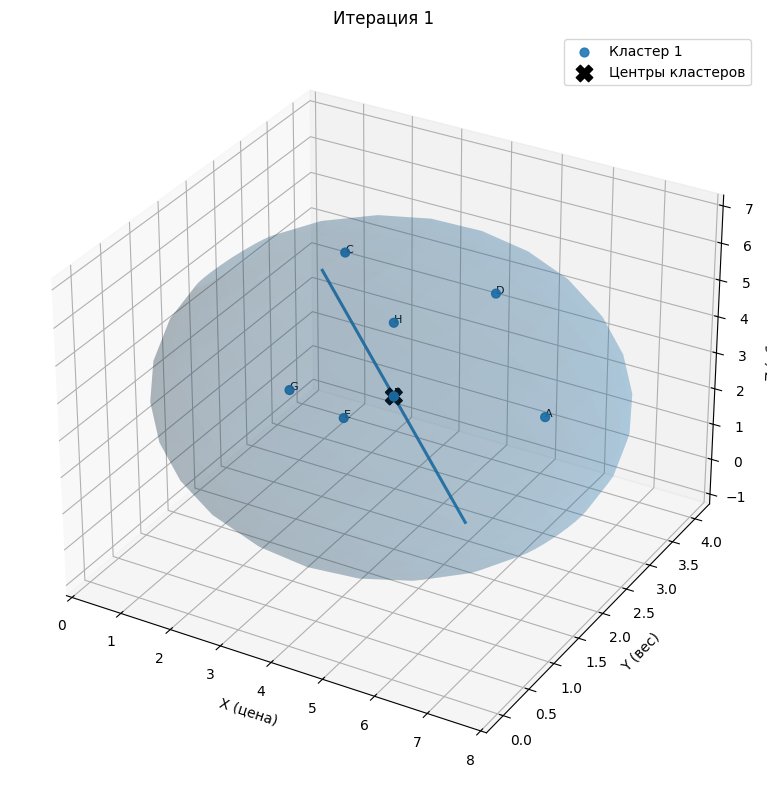

=== Уравнения разделяющих плоскостей ===


<Figure size 640x480 with 0 Axes>

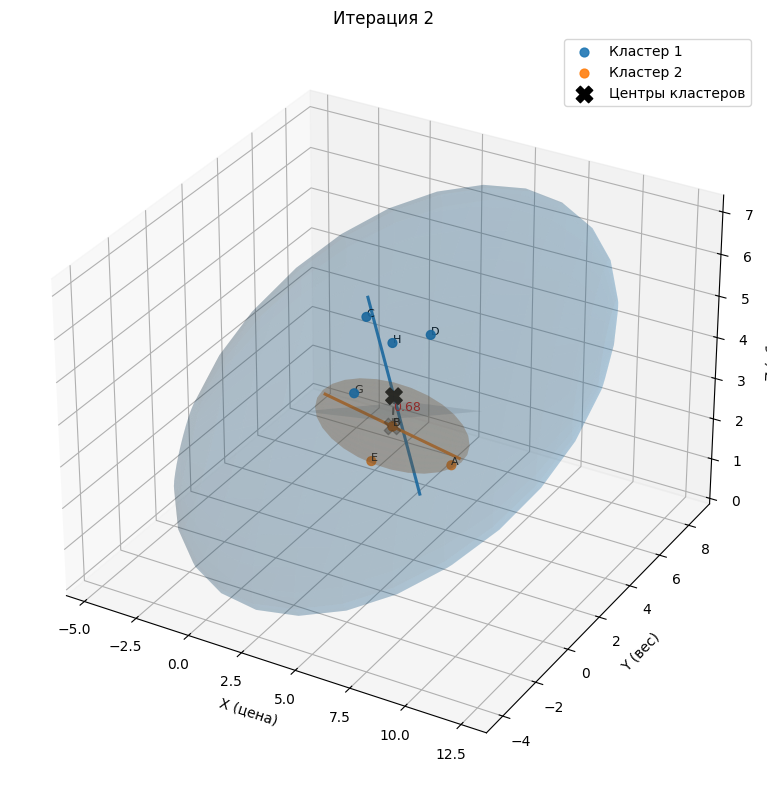

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.125*x + -0.250*y + -0.625*z + 2.109 = 0


<Figure size 640x480 with 0 Axes>

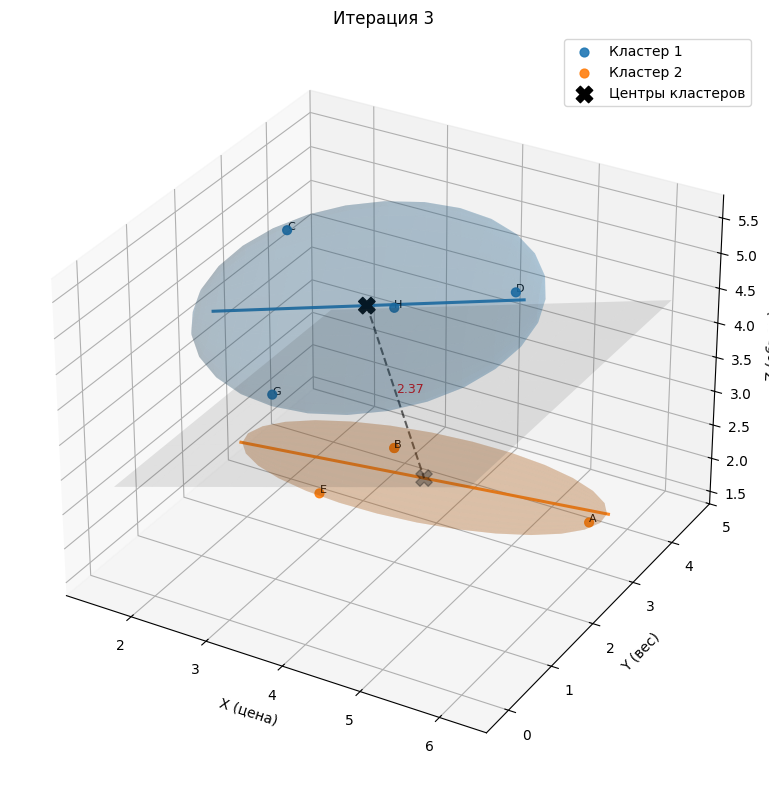

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.750*x + 0.000*y + -2.250*z + 5.250 = 0


<Figure size 640x480 with 0 Axes>

Сошлось на итерации 3


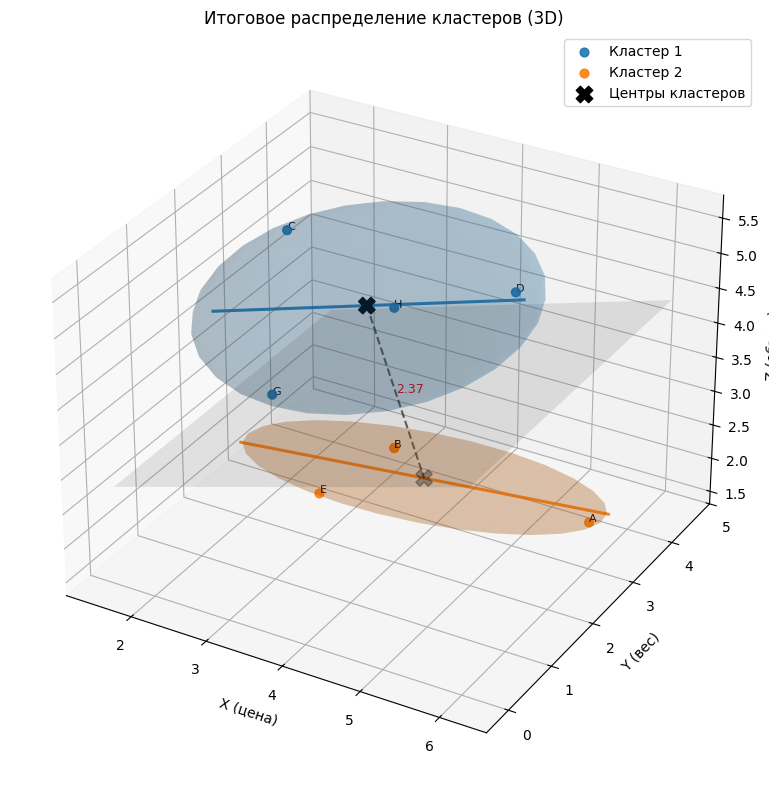

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.750*x + 0.000*y + -2.250*z + 5.250 = 0


<Figure size 640x480 with 0 Axes>

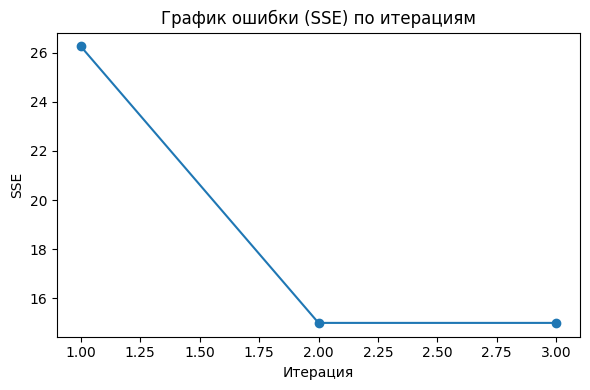

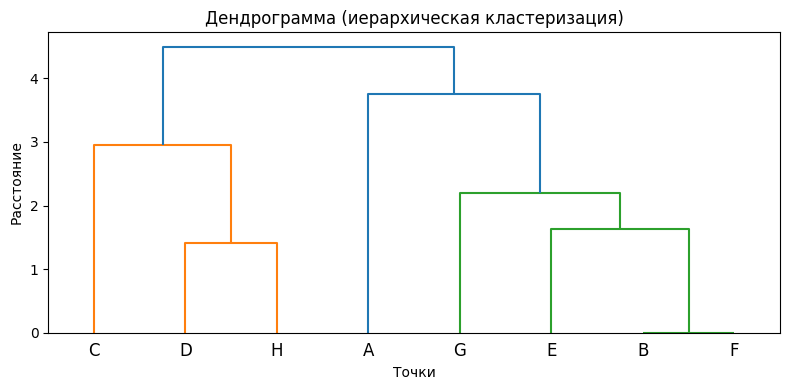

   x  y  z  cluster
A  6  3  2        1
B  4  2  3        1
C  2  3  5        0
D  5  3  5        0
E  3  2  2        1
F  4  2  3        1
G  3  1  4        0
H  4  2  5        0


/tmp/ipykernel_7956/1498434681.py:46: RuntimeWarning: invalid value encountered in divide
  n = normal / np.linalg.norm(normal)


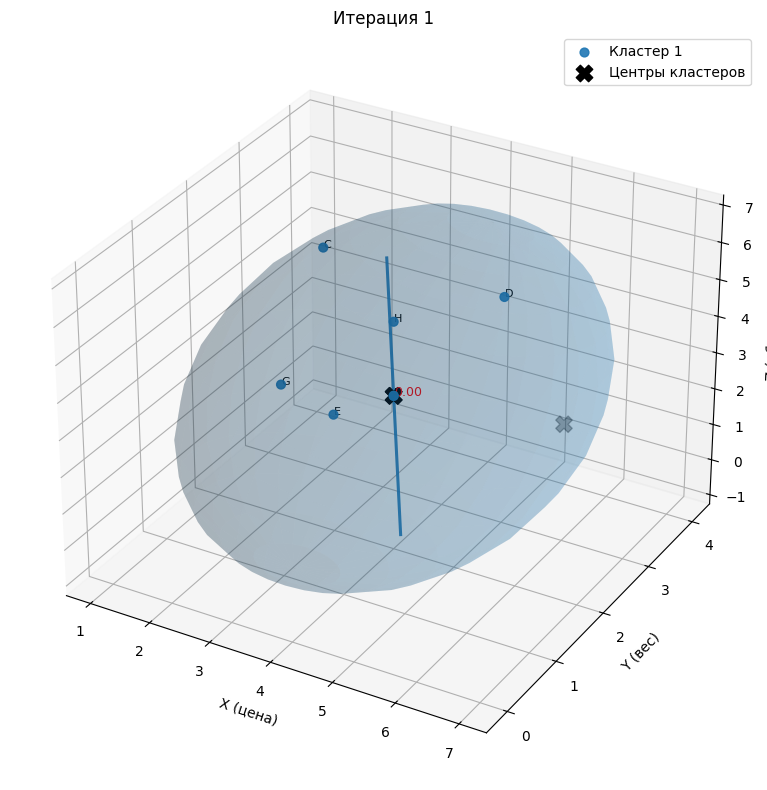

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.000*x + 0.000*y + 0.000*z + -0.000 = 0


<Figure size 640x480 with 0 Axes>

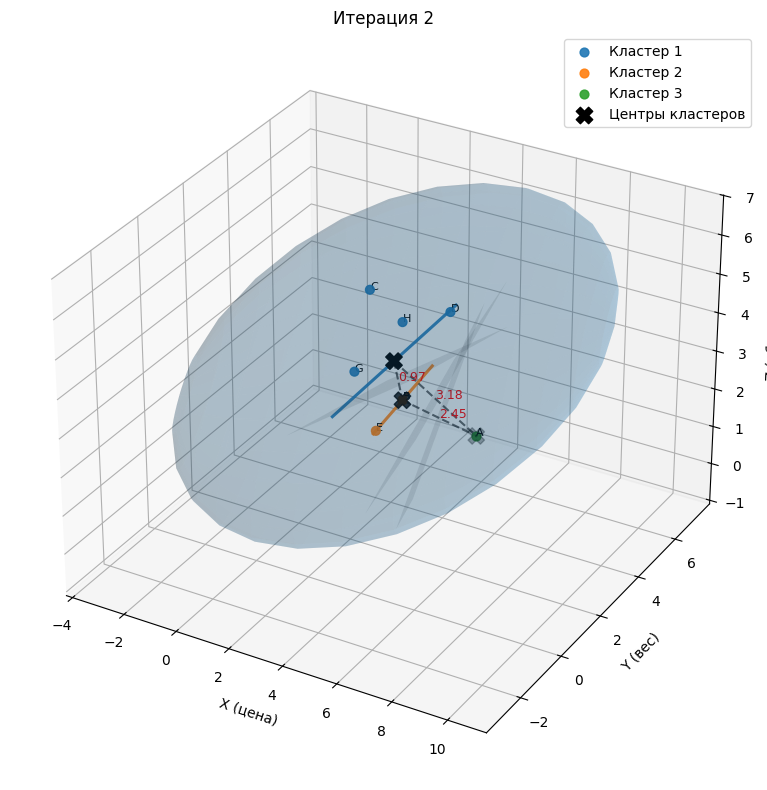

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.429*x + -0.143*y + -0.857*z + 1.612 = 0
Между кластером 0 и 2: 2.429*x + 0.857*y + -1.857*z + -8.388 = 0
Между кластером 1 и 2: 2.000*x + 1.000*y + -1.000*z + -10.000 = 0


<Figure size 640x480 with 0 Axes>

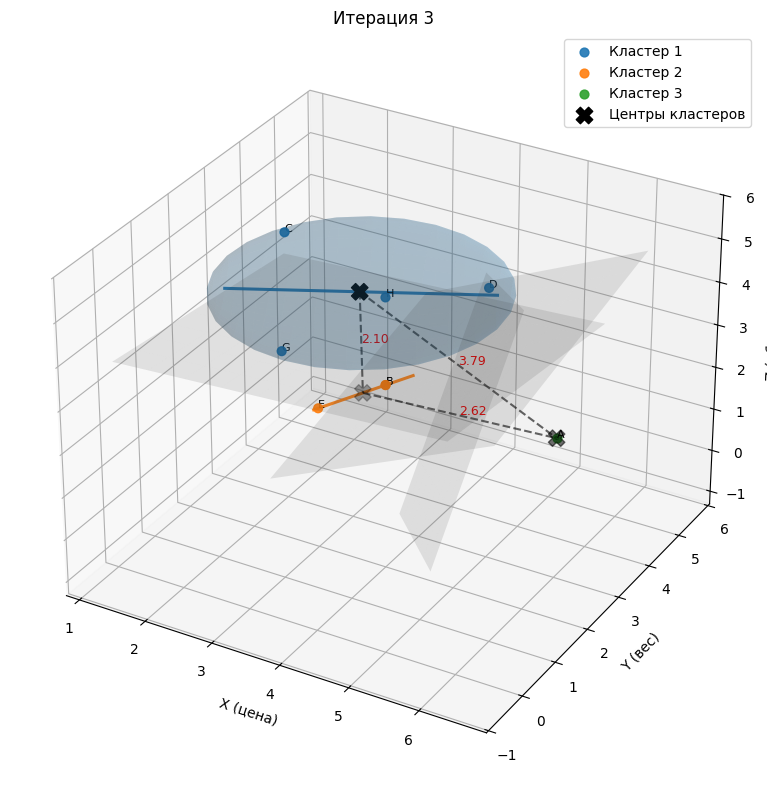

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.167*x + -0.250*y + -2.083*z + 7.660 = 0
Между кластером 0 и 2: 2.500*x + 0.750*y + -2.750*z + -4.562 = 0
Между кластером 1 и 2: 2.333*x + 1.000*y + -0.667*z + -12.222 = 0


<Figure size 640x480 with 0 Axes>

Сошлось на итерации 3


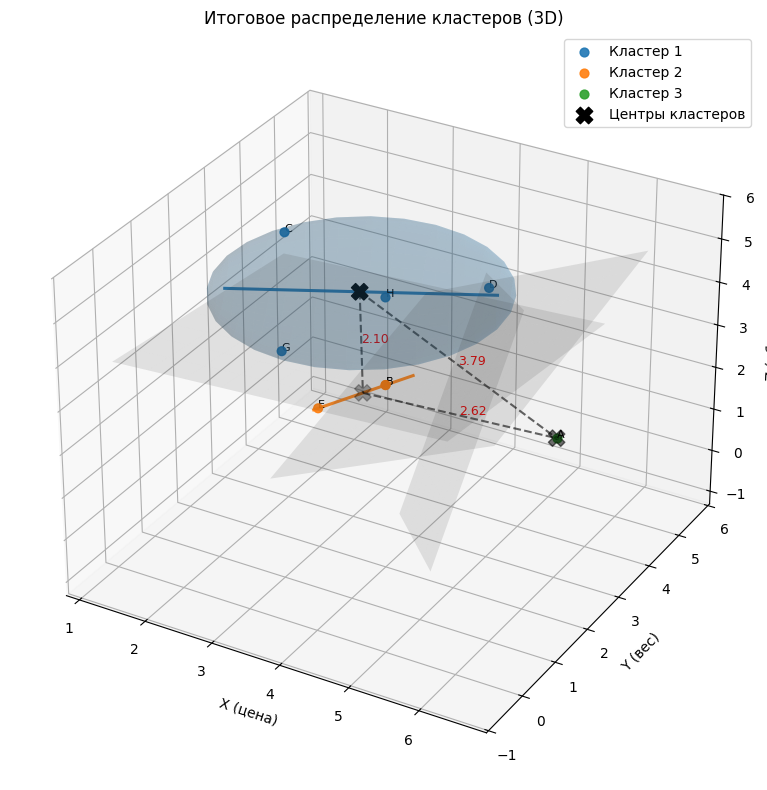

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.167*x + -0.250*y + -2.083*z + 7.660 = 0
Между кластером 0 и 2: 2.500*x + 0.750*y + -2.750*z + -4.562 = 0
Между кластером 1 и 2: 2.333*x + 1.000*y + -0.667*z + -12.222 = 0


<Figure size 640x480 with 0 Axes>

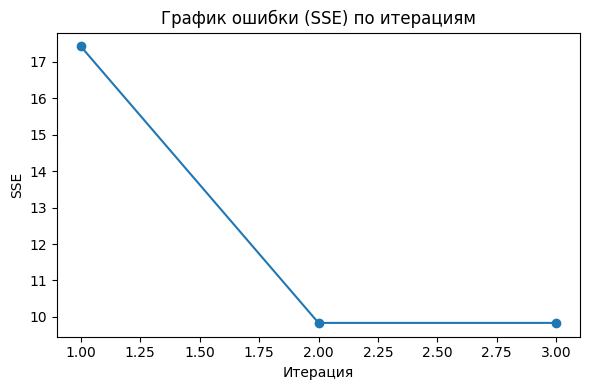

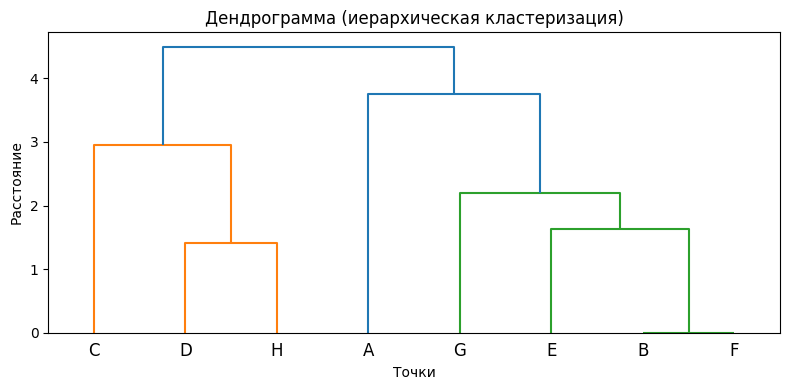

   x  y  z  cluster
A  6  3  2        2
B  4  2  3        1
C  2  3  5        0
D  5  3  5        0
E  3  2  2        1
F  4  2  3        1
G  3  1  4        0
H  4  2  5        0


/tmp/ipykernel_7956/1498434681.py:46: RuntimeWarning: invalid value encountered in divide
  n = normal / np.linalg.norm(normal)


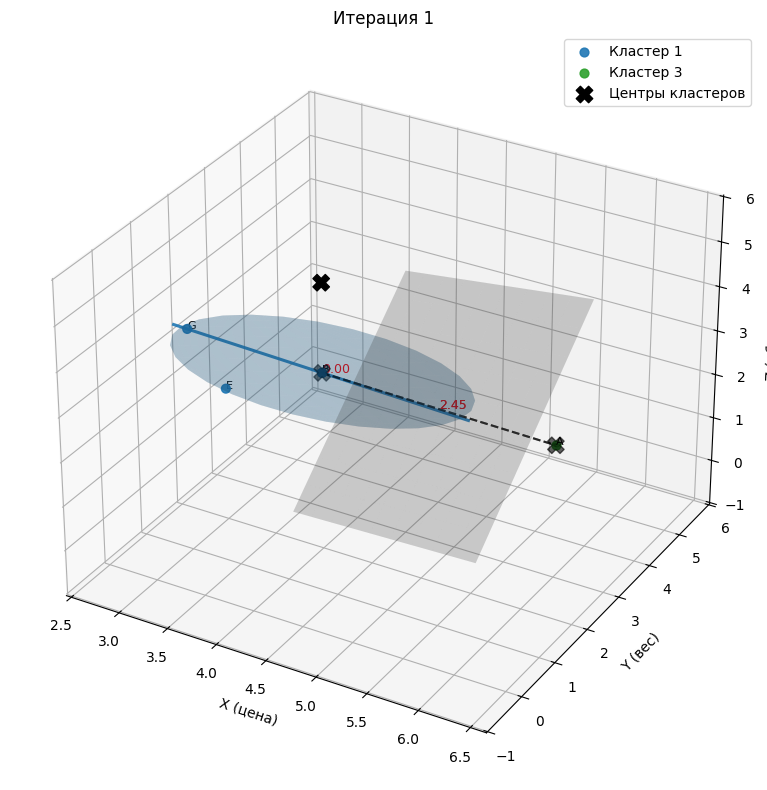

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.000*x + 0.000*y + 0.000*z + -0.000 = 0
Между кластером 0 и 2: 2.000*x + 1.000*y + -1.000*z + -10.000 = 0
Между кластером 1 и 2: 2.000*x + 1.000*y + -1.000*z + -10.000 = 0


<Figure size 640x480 with 0 Axes>

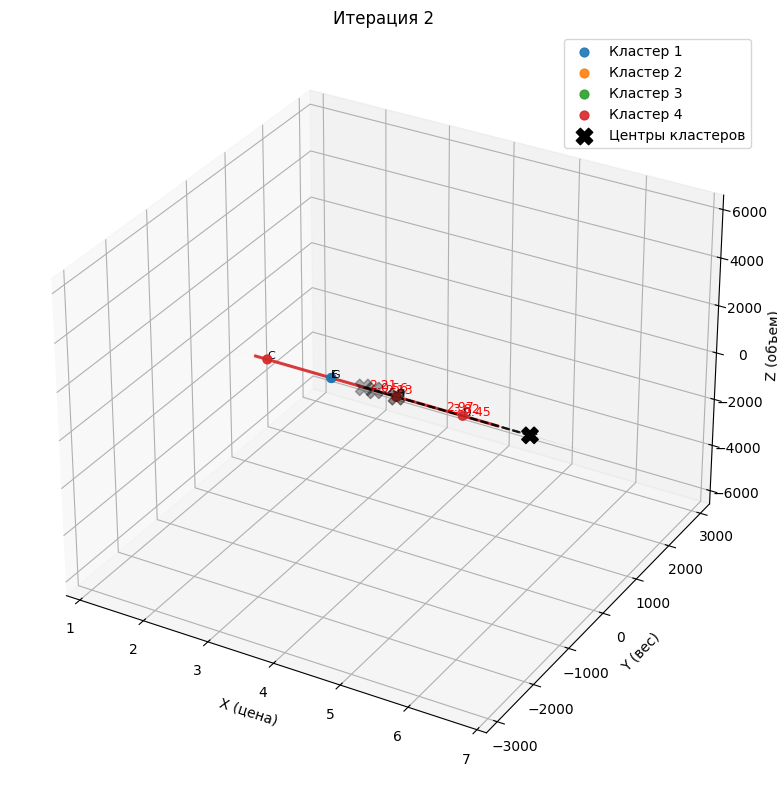

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 0.500*x + 0.250*y + 0.000*z + -2.344 = 0
Между кластером 0 и 2: 2.500*x + 1.250*y + -1.000*z + -12.344 = 0
Между кластером 0 и 3: 0.167*x + 0.917*y + 2.000*z + -10.622 = 0
Между кластером 1 и 2: 2.000*x + 1.000*y + -1.000*z + -10.000 = 0
Между кластером 1 и 3: -0.333*x + 0.667*y + 2.000*z + -8.278 = 0
Между кластером 2 и 3: -2.333*x + -0.333*y + 3.000*z + 1.722 = 0


<Figure size 640x480 with 0 Axes>

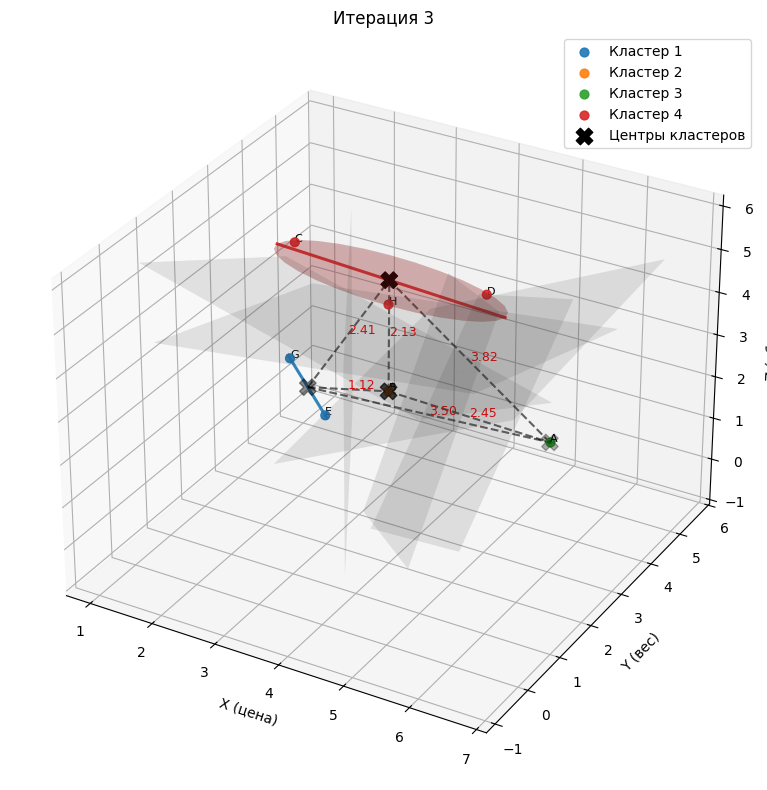

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 1.000*x + 0.500*y + 0.000*z + -4.375 = 0
Между кластером 0 и 2: 3.000*x + 1.500*y + -1.000*z + -14.375 = 0
Между кластером 0 и 3: 0.667*x + 1.167*y + 2.000*z + -12.653 = 0
Между кластером 1 и 2: 2.000*x + 1.000*y + -1.000*z + -10.000 = 0
Между кластером 1 и 3: -0.333*x + 0.667*y + 2.000*z + -8.278 = 0
Между кластером 2 и 3: -2.333*x + -0.333*y + 3.000*z + 1.722 = 0


<Figure size 640x480 with 0 Axes>

Сошлось на итерации 3


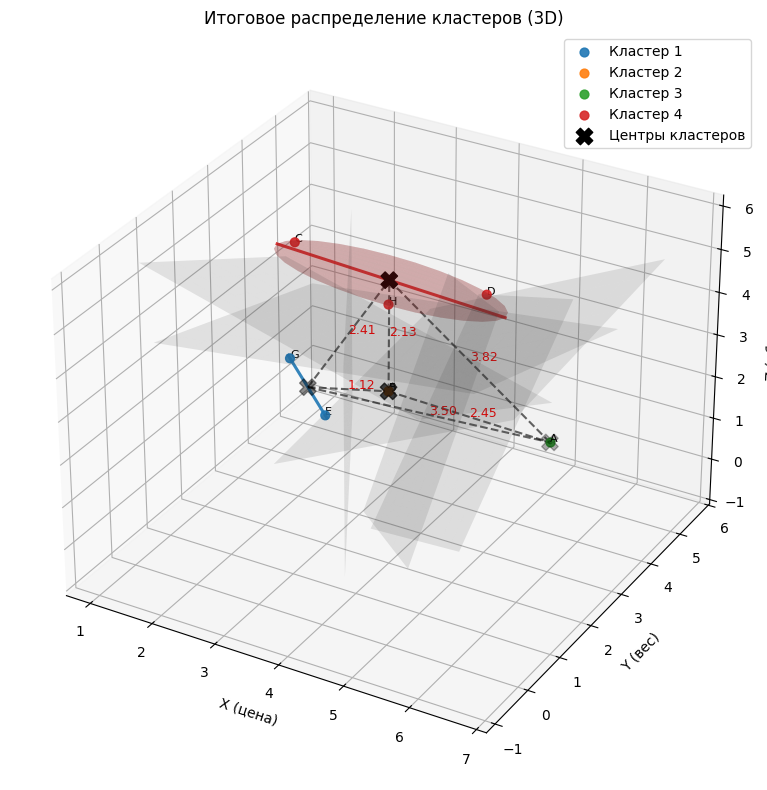

=== Уравнения разделяющих плоскостей ===
Между кластером 0 и 1: 1.000*x + 0.500*y + 0.000*z + -4.375 = 0
Между кластером 0 и 2: 3.000*x + 1.500*y + -1.000*z + -14.375 = 0
Между кластером 0 и 3: 0.667*x + 1.167*y + 2.000*z + -12.653 = 0
Между кластером 1 и 2: 2.000*x + 1.000*y + -1.000*z + -10.000 = 0
Между кластером 1 и 3: -0.333*x + 0.667*y + 2.000*z + -8.278 = 0
Между кластером 2 и 3: -2.333*x + -0.333*y + 3.000*z + 1.722 = 0


<Figure size 640x480 with 0 Axes>

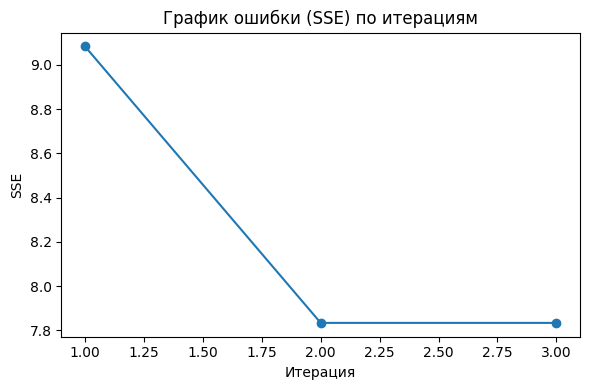

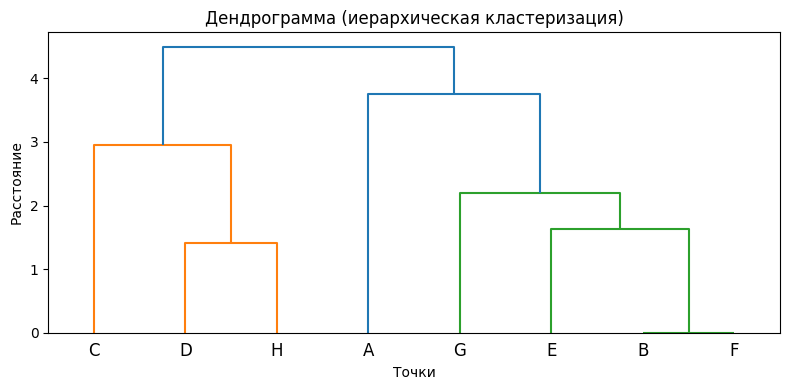

   x  y  z  cluster
A  6  3  2        2
B  4  2  3        1
C  2  3  5        3
D  5  3  5        3
E  3  2  2        0
F  4  2  3        1
G  3  1  4        0
H  4  2  5        3


In [17]:
sum_errors = []
count = int(input("Введите макс. количество кластеров:"))
for k in range(2, count + 1):
    result, centroids, errors = k_means(df, k=k, max_iter=10)
    sum_errors.append(errors[-1])
    print(result)

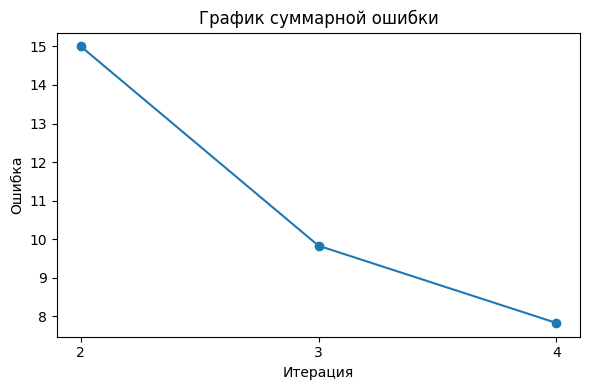

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(2, count + 1, dtype=int), sum_errors, marker='o')
plt.xticks(np.arange(2, count + 1, dtype=int))
plt.title('График суммарной ошибки')
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.tight_layout()
plt.show()